<a href="https://colab.research.google.com/github/AgustinaInsua/TP-LABO-GRUPO4/blob/main/pruebakmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar las librerias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError



Leer el archivo .csv

In [ ]:
url = 'https://github.com/AgustinaInsua/TP-LABO-GRUPO4/raw/main/info2018.csv'
nrows_to_read = 1000  # Cambia este valor al número de filas que desees cargar
data = pd.read_csv(url, nrows=nrows_to_read)

data


,departamento_id,departamento_nombre,provincia_id,provincia_nombre,año,semanas_epidemiologicas,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos
0,760,SAN MIGUEL,6,Buenos Aires,2018,18,Bronquiolitis en menores de 2 años,2,6 a 11 m,2
1,760,SAN MIGUEL,6,Buenos Aires,2018,18,Bronquiolitis en menores de 2 años,3,12 a 23 m,3
2,14,CAPITAL,14,Córdoba,2018,21,Enfermedad tipo influenza (ETI),4,2 a 4,1
3,427,LA MATANZA,6,Buenos Aires,2018,19,Neumonía,5,5 a 9,2
4,427,LA MATANZA,6,Buenos Aires,2018,19,Bronquiolitis en menores de 2 años,2,6 a 11 m,2
...,...,...,...,...,...,...,...,...,...,...
995,260,ESTEBAN ECHEVERRÍA,6,Buenos Aires,2018,18,Enfermedad tipo influenza (ETI),9,25 a 34,4
996,260,ESTEBAN ECHEVERRÍA,6,Buenos Aires,2018,18,Enfermedad tipo influenza (ETI),10,35 a 44,4
997,260,ESTEBAN ECHEVERRÍA,6,Buenos Aires,2018,18,Enfermedad tipo influenza (ETI),12,65 a 74,7
998,14,AÑELO,58,Neuquén,2018,20,Enfermedad tipo influenza (ETI),11,45 a 64,1


In [ ]:
# Función para asignar una región a cada provincia
def assign_region(province):
    if province in ['Corrientes', 'Chaco', 'Misiones', 'Formosa', 'Entre Ríos']:
        return 'Nordeste-Litoral'
    elif province in ['Tucumán', 'Jujuy', 'Salta', 'Catamarca', 'Santiago del Estero']:
        return 'Noroeste'
    elif province in ['San Luis', 'San Juan', 'Mendoza', 'La Rioja']:
        return 'Cuyo'
    elif province in ['Neuquén', 'Río Negro', 'La Pampa']:
        return 'Patagonia Centro-Norte'
    elif province in ['Tierra del Fuego', 'Santa Cruz', 'Chubut']:
        return 'Patagonia Centro-Sur'
    elif province == 'Santa Fe':
        return 'Santa Fe'
    elif province == 'Buenos Aires provincia':
        return 'Buenos Aires'
    elif province == 'Córdoba':
        return 'Córdoba'
    else:
        return 'CABA'
# Limpiar las columnas de cadena para eliminar las comillas dobles
string_columns = ['provincia_nombre']  # Agrega aquí las columnas que son cadenas
for column in string_columns:
    data[column] = data[column].str.replace('"', '')  # Eliminar comillas dobles

# Aplicamos la función a la columna 'PROVINCE' y guardamos el resultado en una nueva columna 'REGION'
data['REGION'] = data['provincia_nombre'].apply(assign_region)
data

KeyError: ignored

In [ ]:
columns_to_drop = ['REGION', 'provincia_nombre', 'departamento_nombre', 'grupo_edad_desc', 'año', 'semanas_epidemiologicas', 'grupo_edad_id']
data = data.drop(columns=columns_to_drop)
data

KeyError: ignored

In [ ]:
# Asignaciones para columnas no númericas
assignment_mapping = {
    'evento_nombre': {
        'Bronquiolitis en menores de 2 años': 2,
        'Enfermedad tipo influenza (ETI)': 3,
        'Neumonía': 1
    }
}

# Limpia valores de las columnas antes de asignar
string_columns = ['evento_nombre']
for column in string_columns:
    data[column] = data[column].str.strip('"')  # Elimina comillas
    data[column] = data[column].str.strip()     # Elimina espacios en blanco

# Aplica las asignaciones
for column, mapping in assignment_mapping.items():
    data[column] = data[column].map(mapping)
data



,provincia_id,evento_nombre,cantidad_casos
0,6,2,2
1,6,2,3
2,14,3,1
3,6,1,2
4,6,2,2
...,...,...,...
995,6,3,4
996,6,3,4
997,6,3,7
998,58,3,1


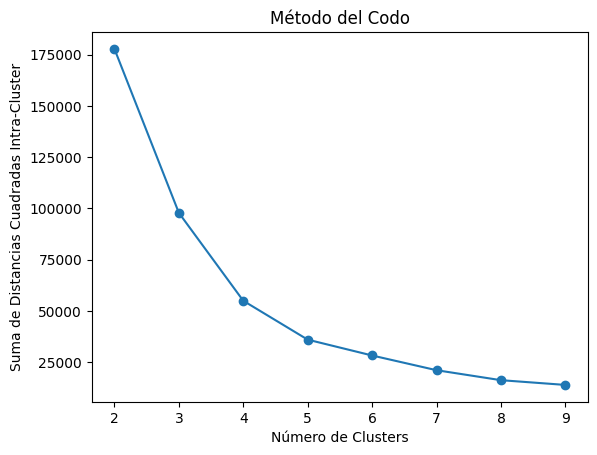

In [ ]:
'''
n_clusters: En el paso de aplicar K-Means calcularemos
la cantidad de clusters con el Método del codo
'''
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# Grafica la suma de las distancias cuadradas intra-cluster en función de k
plt.plot(range(2, 10), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Distancias Cuadradas Intra-Cluster')
plt.title('Método del Codo')
plt.show()

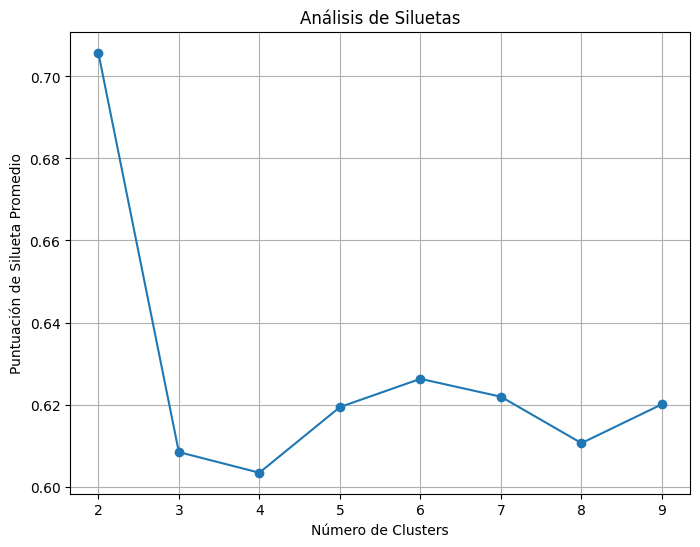

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=0)
    cluster_labels = kmeans.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calcular las puntuaciones de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta Promedio')
plt.title('Análisis de Siluetas')
plt.grid(True)
plt.show()

In [ ]:
# Aplicamos K-Means para clasificar las regiones en grupos
kmeans = KMeans(n_clusters=6, n_init=100, random_state=0).fit(data)

# Asigna un color a cada región en base a los clusters
data['Cluster'] = kmeans.labels_

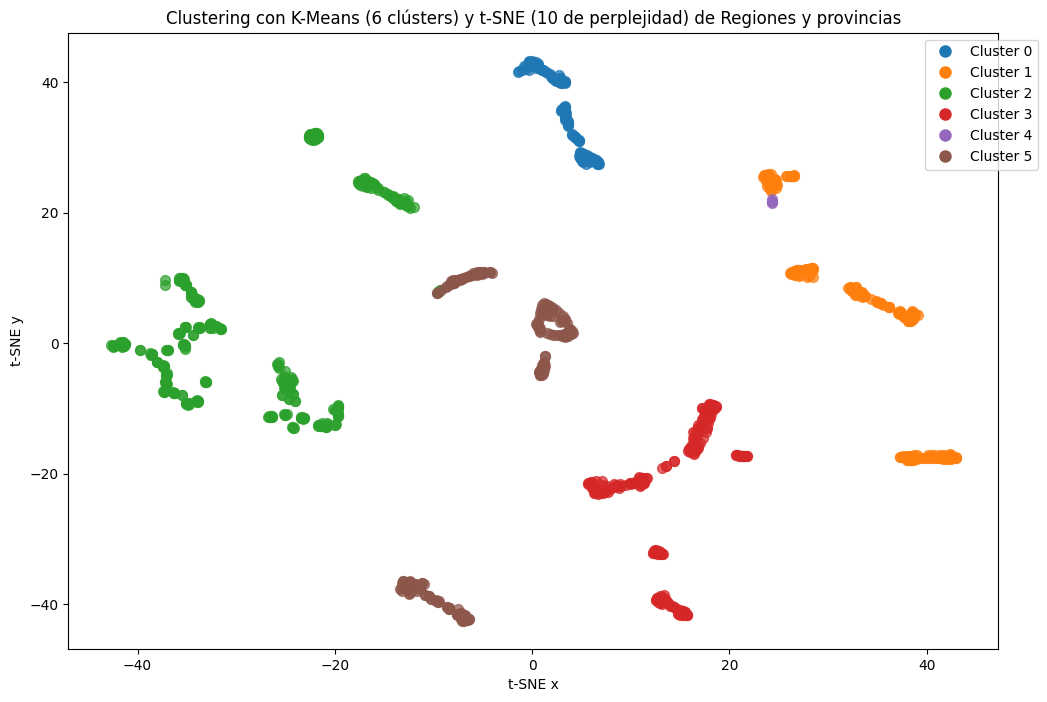

In [ ]:
# Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_coordinates = tsne.fit_transform(data)
data['tsne_x'] = tsne_coordinates[:, 0]
data['tsne_y'] = tsne_coordinates[:, 1]

# Generación de colores para los clusters
cluster_colors = plt.cm.tab10.colors
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(kmeans.labels_)
data['provincia_id'] = data['provincia_id']
for cluster in unique_clusters:
    cluster_data = data[data['Cluster'] == cluster]
    plt.scatter(cluster_data['tsne_x'], cluster_data['tsne_y'],
                label=f'Cluster {cluster}', alpha=0.7, s=50)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=f'C{cluster}', markersize=10, label=f'Cluster {cluster}') for cluster in unique_clusters]

# Coloca la leyenda al costado del gráfico
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.title('Clustering con K-Means (6 clústers) y t-SNE (10 de perplejidad) de Regiones y provincias')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.show()